In [20]:
import pickle
import os

FOLDER = os.getcwd() + "/10_pts_2"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time



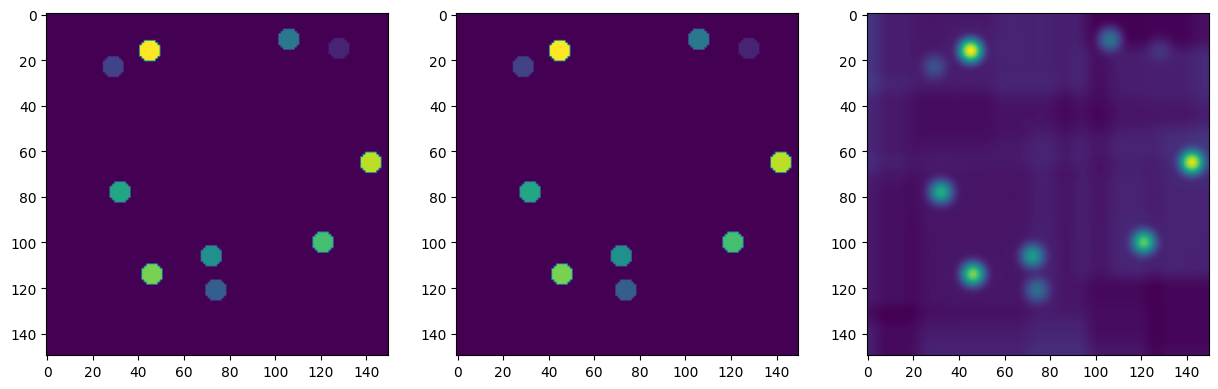

In [22]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

In [23]:
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

with open(FOLDER + '/sourcePts.pkl', 'wb') as file: 
    pickle.dump(sourcePts, file)

"""
for k in sourcePts:
    plt.scatter(k[1],k[0],c='r')
plt.imshow(mask)
"""


690


"\nfor k in sourcePts:\n    plt.scatter(k[1],k[0],c='r')\nplt.imshow(mask)\n"

In [24]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

outputIntensity = {}
(outputWidth, outputHeight) = out.shape

for pt in sourcePts:
    x = pt[0]
    y = pt[1]
    outputIntensity[(x,y)] = AverageFilter(out,x,y)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [26]:
def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

N = len(sourcePts)
distanceMatrix= []
intensityMatrix = []
maskSize = euclideanDistance(mask.shape,(0,0)) 

for idx in range(N):
    current = sourcePts[idx]
    distance = [euclideanDistance(sourcePts[k],current)/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,current[0],current[1])/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Add a bunch of random points
for i in range(outputWidth*outputHeight//25):
    x = random.randint(0,maskWidth-1)
    y = random.randint(0,maskHeight-1)
    if mask[x,y] == 0:
        continue
    distance = [euclideanDistance(sourcePts[k],(x,y))/maskSize for k in range(N)] #Normalise by diagonal length of mask
    intensty = [AverageFilter(out,x,y)/65535] #Normalise by max intensity
    distanceMatrix.append(torch.tensor(distance))
    intensityMatrix.append(torch.tensor(intensty))

#Convert to tensor
distanceMatrix = torch.stack(distanceMatrix)
intensityMatrix = torch.stack(intensityMatrix)

In [27]:
#Create custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, distanceMatrix, intensityMatrix):
        self.distanceMatrix = distanceMatrix
        self.intensityMatrix = intensityMatrix
    def __len__(self):
        return len(self.intensityMatrix)

    def __getitem__(self, idx):
        return (self.distanceMatrix[idx], self.intensityMatrix[idx]) 
dataset = CustomDataset(distanceMatrix, intensityMatrix)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=2)

In [28]:
class Net(nn.Module):
    def __init__(self,N,output_intensity=None):
        super(Net, self).__init__()
        self.polynomial_degree = 7
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        #self.polynomial_weights.weight.data[0][0] = 0
        self.actual_intensity = nn.Linear(N,1,bias=False)
        if output_intensity is not None:
            for i in range(N):
                self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x


In [29]:
model = Net(N,intensityMatrix.data.flatten())
model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
#model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial

#Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD([
                    {'params': model.polynomial_weights.parameters(), 'lr': 0.001},
                    {'params': model.actual_intensity.parameters(), 'lr': 0.001}
                ], lr=0.001, momentum=0.9)


In [30]:
#Training loop

EPOCH = 200
timestr = time.strftime("%Y%m%d-%H%M%S")
PATH = FOLDER + "/model-"+timestr+".pt"


for epoch in range(EPOCH):  # loop over the dataset multiple times
    print("Epoch: ",epoch+1)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data
        # forward + backward + optimize
        nn_outputs = model(inputs)
        loss = criterion(nn_outputs.float(), outputs.float())
        loss.backward()
        optimizer.step()
        model.actual_intensity.weight.data.clamp_(0, 1) #Clamp parameters of last layer
        #model.polynomial_weights.bias.data.clamp_(1, 1) #Clamp parameters of const of polynomial
        # print statistics
        running_loss += loss.item()
    print("Loss: ",running_loss)
print('Finished Training')

loss = criterion(nn_outputs.float(), outputs.float())

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'N': N,
            }, PATH)


Epoch:  1
Loss:  71218.1015625
Epoch:  2
Loss:  22.653820037841797
Epoch:  3
Loss:  0.19059661030769348
Epoch:  4
Loss:  0.19059661030769348
Epoch:  5
Loss:  0.19059661030769348
Epoch:  6
Loss:  0.19059661030769348
Epoch:  7
Loss:  0.19059661030769348
Epoch:  8
Loss:  0.19059661030769348
Epoch:  9
Loss:  0.19059661030769348
Epoch:  10
Loss:  0.19059661030769348
Epoch:  11
Loss:  0.19059661030769348
Epoch:  12
Loss:  0.1905965954065323
Epoch:  13
Loss:  0.19059661030769348
Epoch:  14
Loss:  0.19059661030769348
Epoch:  15
Loss:  0.19059661030769348
Epoch:  16
Loss:  0.19059661030769348
Epoch:  17
Loss:  0.19059661030769348
Epoch:  18
Loss:  0.19059661030769348
Epoch:  19
Loss:  0.19059661030769348
Epoch:  20
Loss:  0.1905965954065323
Epoch:  21
Loss:  0.1905965954065323
Epoch:  22
Loss:  0.1905965954065323
Epoch:  23
Loss:  0.1905965954065323
Epoch:  24
Loss:  0.19059661030769348
Epoch:  25
Loss:  0.19059661030769348
Epoch:  26
Loss:  0.19059661030769348
Epoch:  27
Loss:  0.1905966103076

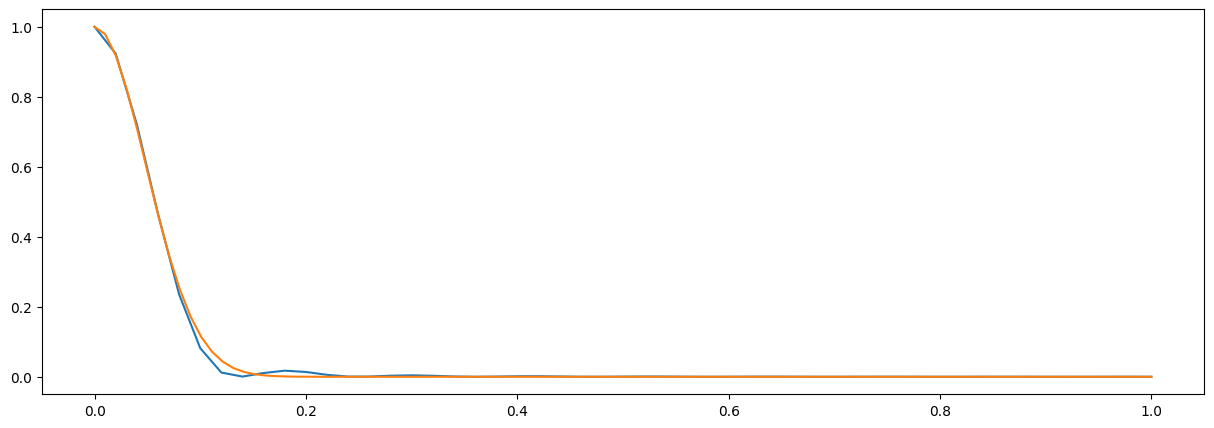

In [31]:
#Checks our model's psf against original psf

with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_x = [np.linspace(0,1,100,dtype=np.float32)]
new_psf_y = model.getPSF(torch.tensor(new_psf_x))
new_psf_x = new_psf_x[0]
new_psf_y = new_psf_y.detach().numpy().flatten()
plt.plot(new_psf_x,new_psf_y)
plt.show()


In [32]:
print(model.polynomial_weights.weight.data)
print(model.actual_intensity.weight.data)

tensor([[-2.1291e+02, -4.9011e+01, -1.3036e+01, -3.7624e+00, -8.8562e-01,
          5.2394e-02, -4.5822e-01]])
tensor([[4.7333e-03, 8.4413e-03, 6.1620e-03, 1.0448e-02, 0.0000e+00, 4.4949e-03,
         3.6367e-03, 0.0000e+00, 1.0227e-02, 4.4683e-03, 9.5174e-03, 7.5861e-03,
         7.5954e-03, 1.0565e-02, 5.0200e-03, 6.8314e-03, 9.1563e-03, 9.9769e-03,
         7.7542e-03, 1.3750e-03, 4.4518e-03, 8.1189e-03, 3.4952e-03, 1.0914e-02,
         7.4327e-03, 4.8088e-03, 1.1280e-02, 5.0328e-03, 7.0653e-03, 2.8538e-03,
         6.7097e-03, 9.4981e-03, 1.0518e-02, 7.0722e-03, 1.0334e-02, 3.7973e-03,
         1.5449e-03, 4.2901e-03, 3.4101e-03, 1.0984e-02, 1.1176e-02, 3.0778e-03,
         6.3212e-03, 1.1271e-03, 6.9329e-03, 7.6928e-03, 8.0418e-03, 8.2333e-03,
         4.2949e-03, 9.9959e-03, 0.0000e+00, 1.6702e-03, 6.1837e-05, 1.5483e-03,
         4.0515e-03, 3.5315e-03, 1.5738e-04, 1.2411e-03, 1.6218e-03, 1.7797e-03,
         5.2387e-05, 6.9210e-03, 9.4993e-03, 3.8367e-03, 0.0000e+00, 7.7476e-03

0.011426260694861412


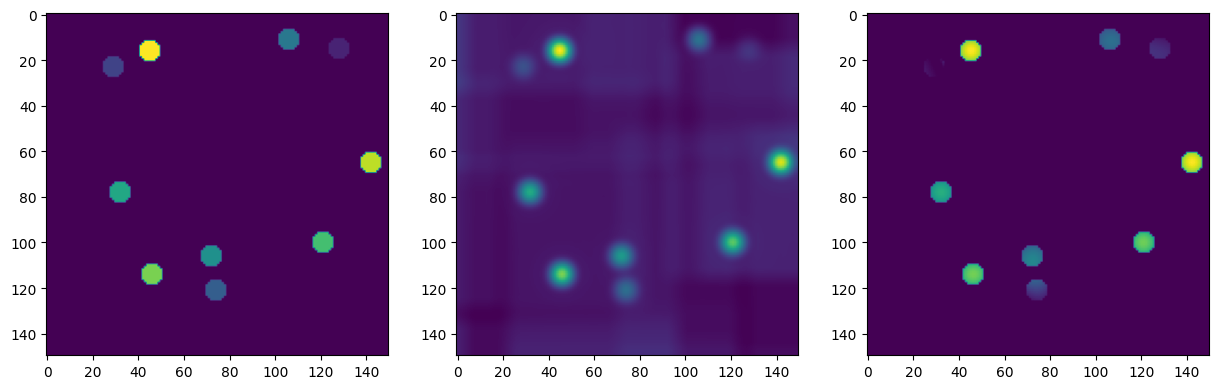

In [35]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)
plt.show()


array([[1.        , 0.97185625],
       [0.97185625, 1.        ]])

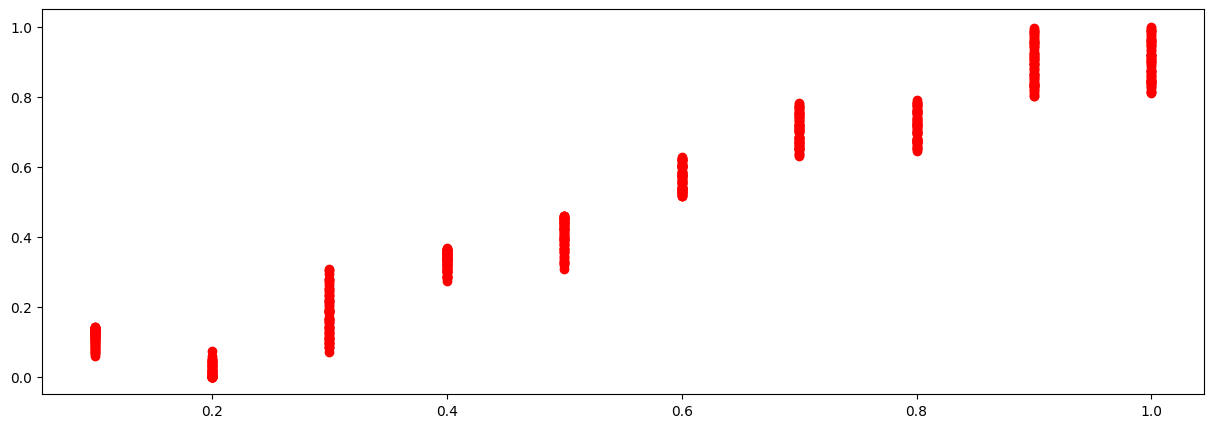

In [34]:
original_intensity = []
custom_intensity = []

for i in range(len(modelIntensity)):
    original_intensity.append(oriNormalised[sourcePts[i][0]][sourcePts[i][1]])
    custom_intensity.append(customOriginal[sourcePts[i][0]][sourcePts[i][1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)